# Описание проекта 

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами. Основаная проблема - отток клиентов. В рамках данного проекта необходимо провести анализ имеющихся текущих метрик и подготовить план действий по удержанию клиентов, а так же: 
1. Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
2. Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
3. Проанализировать основные признаки, наиболее сильно влияющие на отток;
4. Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

    a) выделить целевые группы клиентов;
    
    b) предложить меры по снижению оттока;
    
    c) определить другие особенности взаимодействия с клиентами.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings 
warnings.filterwarnings('ignore')

## Знакомство и предобработка данных

Посмотрю на данные. Оценю, требуется ли предобработка. Если да, сделаю. 
Для оценки качества полученных данных я воспользуюсь несколькими методами:

1. `.info()` для вывода краткой общей информации о таблице;
2. `.columns` для проверки корректности стилистики названий столбцов;
3.  `duplicated().sum()` для проверки на дубликаты.

У меня подготовлена небольшая функция. Использую ее. 

In [2]:
def description(data):
    display(data.head())
    print('Наименования столбцов датафрейма')
    print(data.columns)
    print(f'Кол-во явных дубликатов:{data.duplicated().sum()}')
    data.info()

In [3]:
df = pd.read_csv('~gym_churn.csv')

In [4]:
description(df)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Наименования столбцов датафрейма
Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn'],
      dtype='object')
Кол-во явных дубликатов:0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_vis

**Промежуточный вывод**

1. Немного необходимо поработать с заголовками для удобства их чтения.
2. Хорошо, что нет явных дубликатов в данных. 
3. Также хорошо, что нет пропусков в данных. 
4. Типы данных соответствуют самим данным. 

Приведу заголовки к нижнему регистру.

In [5]:
df.columns = [x.lower() for x in df.columns]

Посмотрим также на сами данные с помощью метода `describe()`.

In [6]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Что видим:**
1. Поскольку первые 5 столбцов с данными носят бинарный характер (либо "1" либо "0"). 
2. Мв видим, что в среднем дополнительная выручка от непрофильной деятельности на одного посетителя составляет почти 147 у.е., тогда как медианное значение равно 136 у.е. Это говорит о том, что большого кол-ва выбросов по данному столбцу нет. При этом стандарное отклонение имеет высокое значение - 96. Чуть дальше построю гистограмму, чтобы посмотреть визуально на распределение и на соответствие правилу 3-х сигм;
3. С точки зрения частоты посещения в неделю мы видим, что клиенты сети в среднем приходят в фитнес-центр 2 раза в неделю. Медианное значение очень близко к среднему арифметическому, а стандартное отклонение равно 1. Предположу, что по данному столбцу выбросов немного. Отмечу, что в предыдущем месяце клиенты посещали чуть-чуть реже фитнес-центры, чем в среднем  с начала действия абонемента;
4. Также видно, что в среднем у клиентов фитнес-центров остается чуть больше 3,5 месяцев до истечения срока действия абонемента. Тот факт, что среднее арифметическое значение по данному столбцу чуть выше медианного говорит о том, что людей с бОльшей остаточной длительностью абонемента чуть больше, чем клиентов с меньшей. Тут есть небольшое смещение распределения данных вправо. 


### Анализ средних значений признаков в двух группах
В наших данных также есть столбец с обозначением факта оттока в этом месяце. Там отражены 2 значения: "1" и "0". Разделю данные на 2 группы и посмотрю на средние показатели с учетом сегментации по столбцу `churn`. Транспонирую данные для более удобного визуального восприятия. 

In [7]:
df.groupby(by='churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


**Что видим:**
1. Видим, что не ушедшие в отток клиенты в среднем чаще посещали фитнес-центры, что уже ушедшие, как в целом с момента начала действия абонемента, так и за предыдущий рассматриваемый месяц. 
2. Ожидаемо среднее значение длительности текущего действующего абонемента у неушедших больше, чем у тех, кто числится в оттоке. 
3. Более того, группа активных клиентов тратит больше денег на дополнительные услуги в фитнес-центрах. 
4. Они же в среднем чаще ходят на групповые занятия. 
5. Клиенты, попавшие в группу "0" почти в 2 раза чаще использовали промокод от знакомого при оплате первого абонемента. 
6. Распределение между мужчинами и женщинами в обоих категориях приблизительно одинаковое. 

### Оценка распределения данных признаков для 2-х групп

Оценим распределение данных по разным критериям и построим гистограммы для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

In [8]:
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

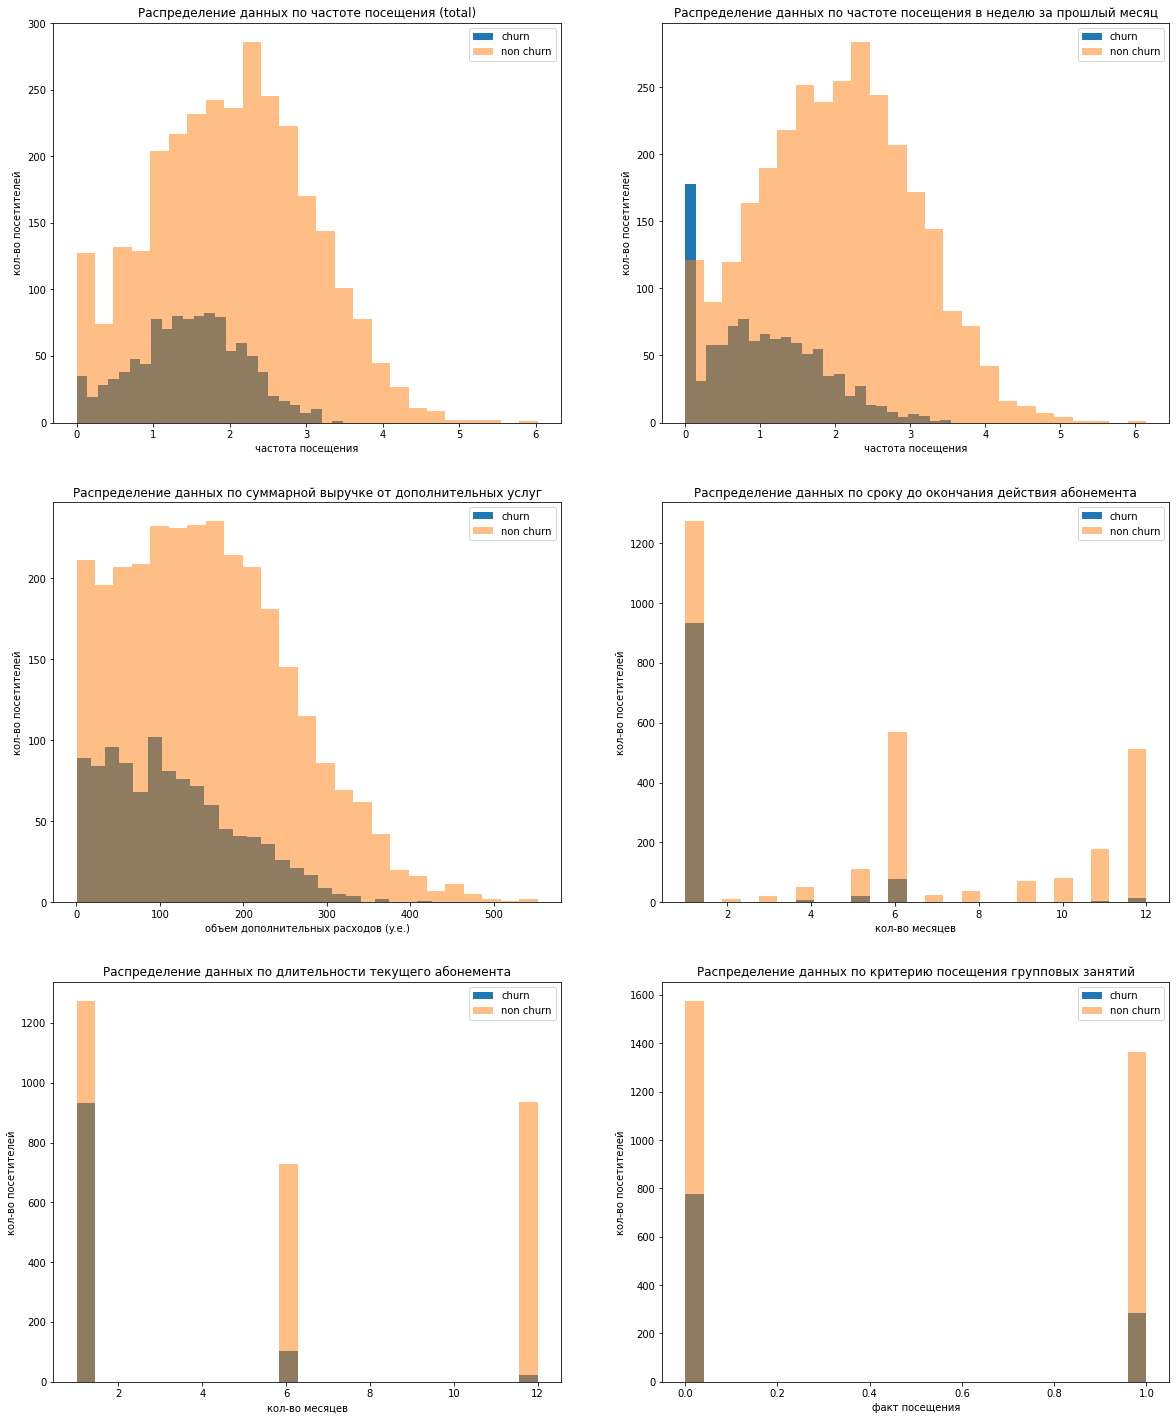

In [9]:
fig = plt.figure(figsize=(20, 25))

ax_1 = fig.add_subplot(3, 2, 1)
ax_1 = df.loc[df['churn'] == 1]['avg_class_frequency_total'].plot(kind='hist', bins=25, linewidth=5, alpha=1, label='churn', legend=True)
df.loc[df['churn'] == 0]['avg_class_frequency_total'].plot(kind='hist', bins=25, linewidth=5, alpha=0.5, label='non churn', ax=ax_1, legend=True)
ax_1.set(title='Распределение данных по частоте посещения (total)', ylabel = 'кол-во посетителей', xlabel ='частота посещения')

ax_2 = fig.add_subplot(3, 2, 2)
ax_2 = df.loc[df['churn'] == 1]['avg_class_frequency_current_month'].plot(kind='hist', bins=25, linewidth=5, alpha=1, label='churn', legend=True)
df.loc[df['churn'] == 0]['avg_class_frequency_current_month'].plot(kind='hist', bins=25, linewidth=5, alpha=0.5, label='non churn', ax=ax_2, legend=True)
ax_2.set(title='Распределение данных по частоте посещения в неделю за прошлый месяц', ylabel = 'кол-во посетителей', xlabel ='частота посещения')

ax_3 = fig.add_subplot(3, 2, 3)
ax_3 = df.loc[df['churn'] == 1]['avg_additional_charges_total'].plot(kind='hist', bins=25, linewidth=5, alpha=1, label='churn', legend=True)
df.loc[df['churn'] == 0]['avg_additional_charges_total'].plot(kind='hist', bins=25, linewidth=5, alpha=0.5, label='non churn', ax=ax_3, legend=True)
ax_3.set(title='Распределение данных по суммарной выручке от дополнительных услуг', ylabel = 'кол-во посетителей', xlabel ='объем дополнительных расходов (y.e.)')

ax_4 = fig.add_subplot(3, 2, 4)
ax_4 = df.loc[df['churn'] == 1]['month_to_end_contract'].plot(kind='hist', bins=25, linewidth=5, alpha=1, label='churn', legend=True)
df.loc[df['churn'] == 0]['month_to_end_contract'].plot(kind='hist', bins=25, linewidth=5, alpha=0.5, label='non churn', ax=ax_4, legend=True)
ax_4.set(title='Распределение данных по сроку до окончания действия абонемента', ylabel = 'кол-во посетителей', xlabel ='кол-во месяцев')

ax_5 = fig.add_subplot(3, 2, 5)
ax_5 = df.loc[df['churn'] == 1]['contract_period'].plot(kind='hist', bins=25, linewidth=5, alpha=1, label='churn', legend=True)
df.loc[df['churn'] == 0]['contract_period'].plot(kind='hist', bins=25, linewidth=5, alpha=0.5, label='non churn', ax=ax_5, legend=True)
ax_5.set(title='Распределение данных по длительности текущего абонемента', ylabel = 'кол-во посетителей', xlabel ='кол-во месяцев')

ax_6 = fig.add_subplot(3, 2, 6)
ax_6 = df.loc[df['churn'] == 1]['group_visits'].plot(kind='hist', bins=25, linewidth=5, alpha=1, label='churn', legend=True)
df.loc[df['churn'] == 0]['group_visits'].plot(kind='hist', bins=25, linewidth=5, alpha=0.5, label='non churn', ax=ax_6, legend=True)
ax_6.set(title='Распределение данных по критерию посещения групповых занятий', ylabel = 'кол-во посетителей', xlabel ='факт посещения')

plt.show()

**Вывод по графикам**

Графики буду анализировать слева направо и сверху вних. 

1. Как видно на первом графике, распределение данных в сегменте действующих клиентов по среднему кол-ву посещений фитнес-центров за все время немного скошено влево. 
    1. Пиковое значение около 2,5 раз в неделю. Также видим, что есть небольшое кол-во "аномально" высоких значений(>4 раз в неделю); 
    2. Стоит также отметить, что распределение данных в сегменте клиентов, которые уже числятся в оттоке очень близко к нормальному, несмотря на небольшое смещение влево. 
    
2. На графике распределения данных по столбцу среднего кол-ва посещений в неделю за предыдущий месяц ситуация схожая в сегменте действующих клиентов. То же смещение влево, при этом кол-во людей, которые посещают фитнес-центры 3 раза в неделю схожее с тем, что видно на графике по среднему посещению за все время наблюдений. 
    1. Однако, больше людей, которые ходили в фитнес-центры больше 3 раз в неделю. 
    2. При этом на графике сегмента `churn` видно явное смещение влево, а пиковое значение равно 0, что говорит о том, что очень большое кол-во посетитиелей фитнес-центров, числящиеся в оттоке, не посещали фитнес-центры в последний месяц. 
    
3. На гистограмме, построенной по критерию суммарной выручки от продажи дополнительных услуг в фитнес-центре, в обоих сегментах видно сильное смещеие влево. 
    1. В семгенте действующих клиентов аномально высокими данными можно считать те, что выше значения в 400 y.e. 
    2. В сегменте посетителей, которые считаются оттоком, таковыми являются превышающие 300 y.e. 
    3. На гистограмме хорошо видно, что действующие клиенты сети фитнес-центров тратят больше средств, чем уже ушедшие. 
    
4. С точки зрения кол-ва оставшихся месяцев у посетителей фитнес-центров видим, что у большинства анализируемых клиентов остался всего один месяц до окончания абонемента, что означает, что в ближайшее время будут требоваться активные действия в отношении клиентов по их удержанию/реактивации. 
    1. Также большое кол-во клиентов с остатком в 6 и 12 месяцев. Предположу, что это совсем новые клиенты сети. 

5. На гистограмме, построенной по признаку длительности текущего действующего абонемента, видно, что рассматриваемая выборка клиентов разделена на 3 группы: 
    1. 1 месяц;
    2. 6 месяцев;
    3. 12 месяцев. 
    
   Видим также, что у большей части тех посетителей, которые уже отнесены к оттоку, остался всего 1 месяц до истечения срока действия абонемента. 
   
   
6. Посетителей, которые ходят на групповые занятия, немного меньше, чем тех, кто их посещает. При этом, разница в сегменте оттока выше, чем в сегменте действующих клиентов. 

Проанализируем также взаимосвязь рассматриваемых нами показателей в нашем датафрейме. 

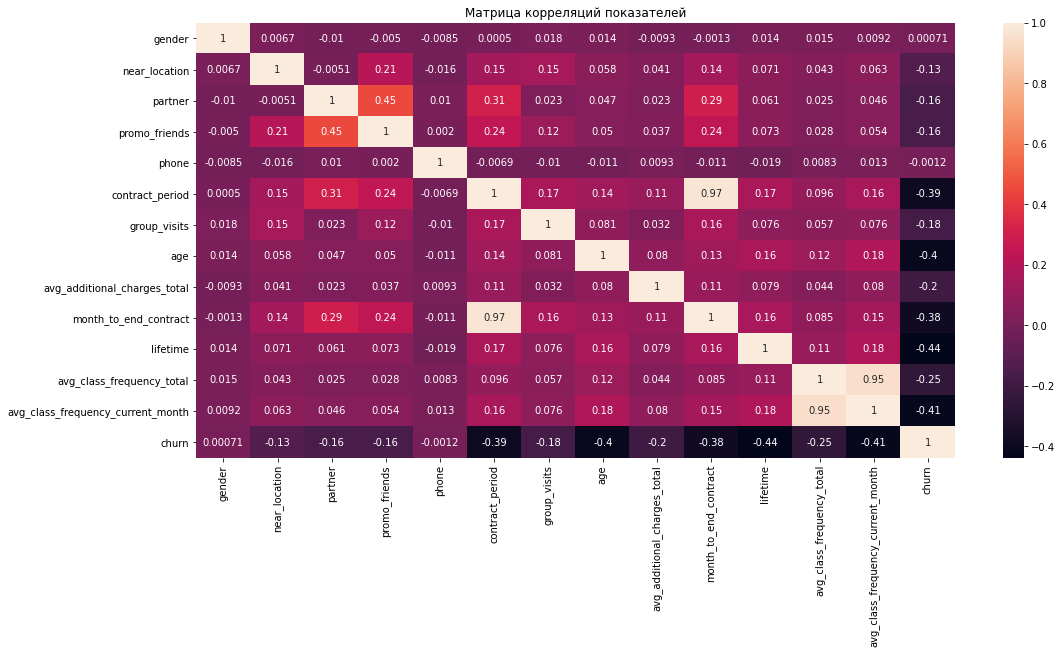

In [10]:
plt.figure(figsize=(17,8))
sns.heatmap(df.corr(), annot=True)
plt.title('Матрица корреляций показателей')
plt.show()

**Что видим:**

1. Очень сильная зависимость между показателями `month_to_end_contract` и `contract_period`.
2. Высокий уровень зависимости между признаками посещения фитнес-центров в целом и посещениями за предыдущий месяц. 
3. Также наблюдаем выскую взаимосвязь между `avg_class_frequency_total` и `avg_class_frequency_current_month`. 
3. Относительно среднюю зависимость между признаками `promo_friends` и `partner`.
4. Относительно среднюю отрицательную зависимость между фактом оттока и временес с момента первого обращения в фитнес-центр. 
5. Достаточно низкую зависимость между остальными показателями, что говорит о том, что в дальнейшем при обучении нам не придется удалять много созависимых признаков. 

В данном случае избавляться от сильно созависимых признаков не стоит, поскольку один из таких признаков вытекает из другого.

### Вывод по знакомству и предобработке

Мы изучаем весьма качественный датафрейм, в котором нет пропусков и явных дубликатов. Кол-во аномально высоких значений немного. С ними, возможно, мы поработаем чуть дальше в проекте. 

## Модели прогнозирования оттока клиентов

Перейдем непосредственно к построению бинарной модели классификации клиентов, в которой целевой признак - факт оттока клиентов в следующем месяце. 

Разделим данные на обучающую и валидационную, а также подготовим необходимые переменные. Целевой признак (`y`) - факт оттока клиента. 

In [11]:
y = df['churn']
X = df.drop(['churn'], axis=1)

Создадим 2 выборки для обучения нашей машины. Для этого разделим данные на обучающую и валидационную выборку. Разделим в пропорции 80 к 20. 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Обучим модель на train-выборке 2-мя способами: 

    1. Логистическая регрессия;
    2. Случайным лесом.
    
Выбор этих методов обусловлен тем, что у нас целевая величина (факт оттока) бинарная. Она принимает значения либо "0" либо "1". 

### Логистическая регрессия

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [14]:
model = LogisticRegression(random_state = 0, solver='liblinear')

model.fit(X_train_st, y_train)

LogisticRegression(random_state=0, solver='liblinear')

Рассчитаем прогноз класса и вероятность принадлежности объекта к первому или второму классу (в нашем случае, к оттоку или не оттоку). 

In [15]:
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]

### Метод случайного леса

In [16]:
model_2 = RandomForestClassifier(random_state=0)

model_2.fit(X_train_st, y_train)

predictions_f = model_2.predict(X_test_st)
probabilities_f = model_2.predict_proba(X_test_st)[:,1]

Сравним модели, посмотрим, какая из них показала себя лучше. Оценим все по трем основным критериям: accuracy, precision и recall. 

In [17]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [18]:
print_all_metrics(
    y_test,predictions, probabilities, 
    title='Метрики для модели логистической регрессии:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97


In [19]:
print_all_metrics(
    y_test,predictions_f, probabilities_f, 
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81
	F1: 0.83
	ROC_AUC: 0.97


Посмотрим сначала на долю правильных ответов. 

92% в обоих моделях - очень высокий показатель.

Теперь взглянем на точность и полноту. 
У модели логистической регрессии этот показатель немного выше (85% против 84% у модели случайного леса). 

С точки зрения того, сколько реальных объектов мы смогли обнаружить, то мы видим, что при применении модели логистической регрессии это показатель на 2 пункта выше - 83% против 81%. 

Посмотрим также на сводную метрику f_1. 
В данному случае модель логистической регрессии также показа себя немного лучше, чем модель случайного леса - 0.84 против 0.83. 

### Вывод по построению и оценке моделей

Построили 2 модели, которые, основываясь на метриках точности, плотности и доли правильных ответов, показали себя хорошо. 

В данному случае модель логистической регрессии показала себя немного лучше.  

## Кластеризация клиентов

Проведем кластеризацию данных о клиентах. 

Поскольку чуть раньше мы выяснили, что распределения данных в основном смещены влево, нам необходимо провести стандартизацию данных, чтобы привести их к виду стандартного нормального распределения. После построю матрицу расстояний и нарисую дендонаграмму.  

In [20]:
sc = StandardScaler()
X_sc = sc.fit_transform(df.drop(columns = ['churn']))

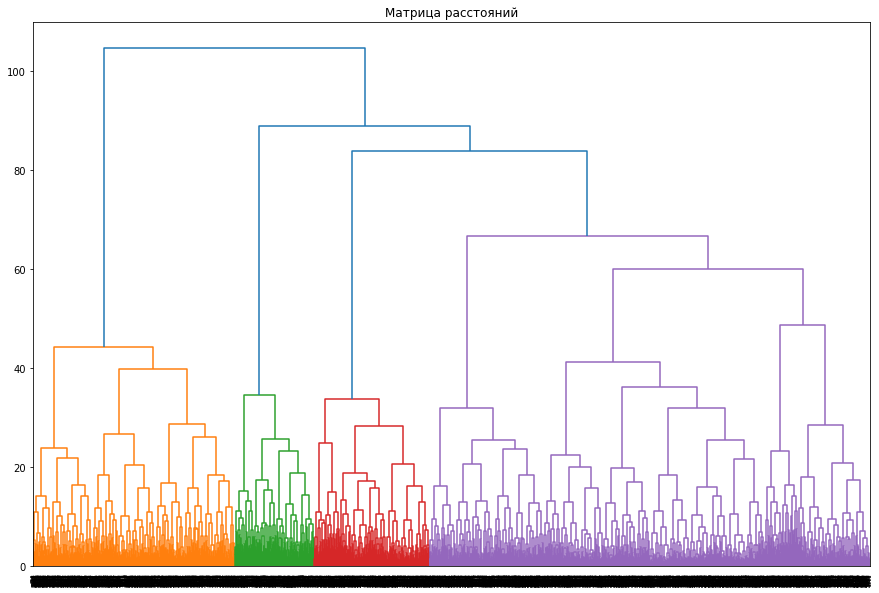

In [21]:
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Матрица расстояний')
plt.show() 

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

Чтобы не потерять удачный вариант кластеризации, зафиксируем случайное состояние алгоритма. Для этого параметру random_state передадим значение 0.

In [22]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)

In [23]:
df['cluster_km'] = labels
display(df.drop(columns = ['churn']).groupby(['cluster_km']).mean().T)

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


Получили небольшую таблицу со средними значениями признаков для кластеров. 
В глаза бросается сразу несколько пунктов: 

    1. Пользователи первого кластера чаще других пользуются промокодом от друзей. 
    2. 2-й кластер вообще не пользуется мобильной связью. Во всяком случае клиенты этого кластера не указали свой номер телефона. С данным кластером не стоит выстраивать холодные продажи традиционным образом (по телефону). Это будет бесполезно. 
    3. Средний возвраст всех 5 кластеров приблизительно одинаковый. Разница совсем не существенная. 
    4. Клиенты, попавшие в 5-й кластер, больше других тратят денежные средства на дополнительные услуги в фитнес-центре. Чуть меньше затрат у пользователей 1-го кластера. 
    5. Самое большое время до окончания абонемента у клиентов, попавших в первый кластер. 
    6. Самое маленькое время до окончания абонемента у клиентов, попавших в 4-й кластер. 
    7. Чаще всего в среднем в фитнес-центры ходят клиенты 5-го кластера, как в целом за все время, так и за последний месяц. 
    8. Реже всех остальных в фитнес-центры ходят клиенты 4-го кластера одинаково за все периоды          наблюдений. 

Посмотрим распределения признаков для кластеров наглядно. 

In [24]:
def get_hist(x, key_cols):
    x_new = x.copy()
    x_new[key_cols] = df[key_cols]
    for c in key_cols[:-1]:
        print('Распределение признака {} по кластерам'.format(c))
        sns.displot(data=x_new, x=x_new[c], col='cluster_km', height=4, aspect=0.7)
        plt.show()

Распределение признака gender по кластерам


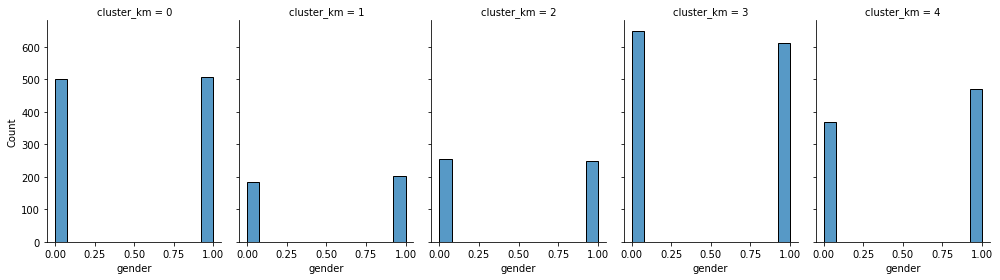

Распределение признака near_location по кластерам


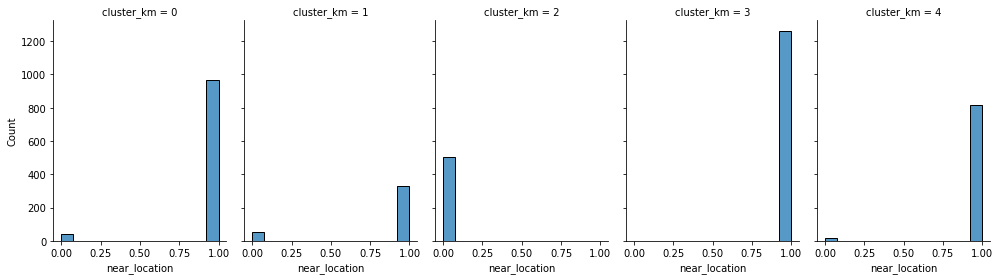

Распределение признака partner по кластерам


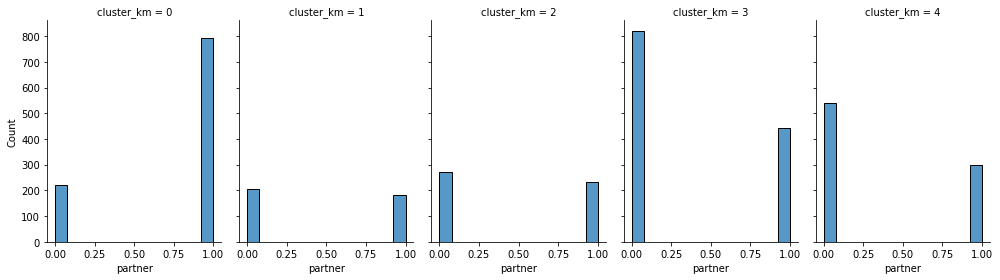

Распределение признака promo_friends по кластерам


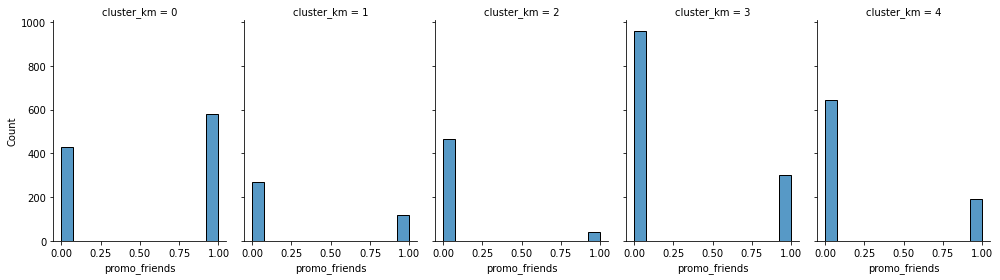

Распределение признака phone по кластерам


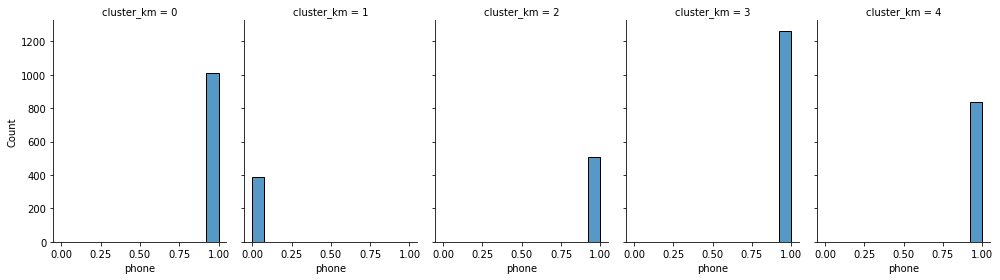

Распределение признака contract_period по кластерам


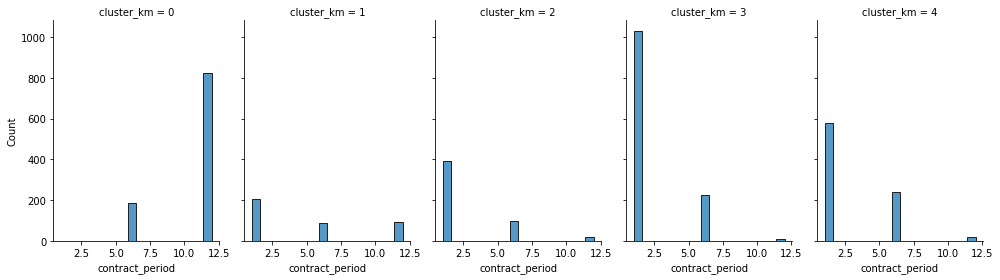

Распределение признака group_visits по кластерам


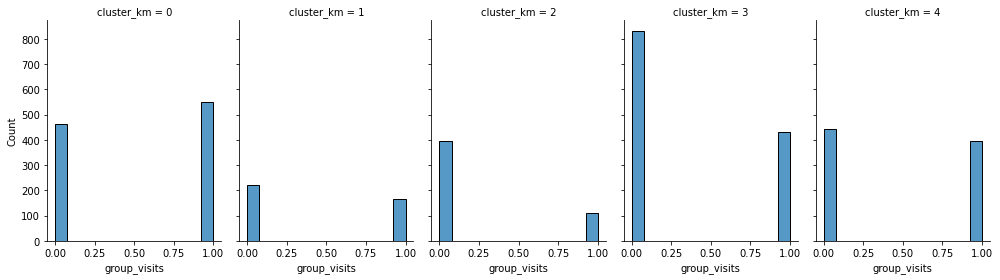

Распределение признака age по кластерам


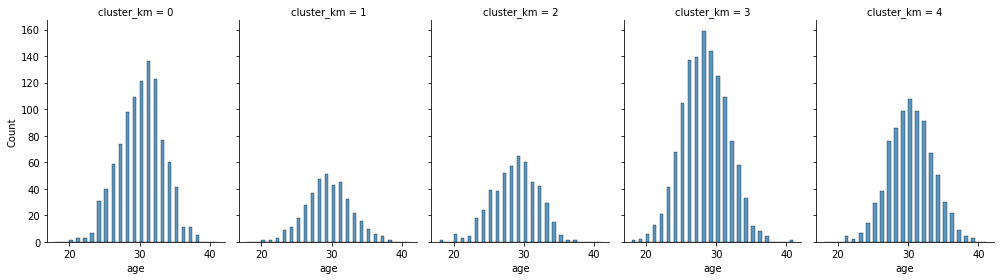

Распределение признака avg_additional_charges_total по кластерам


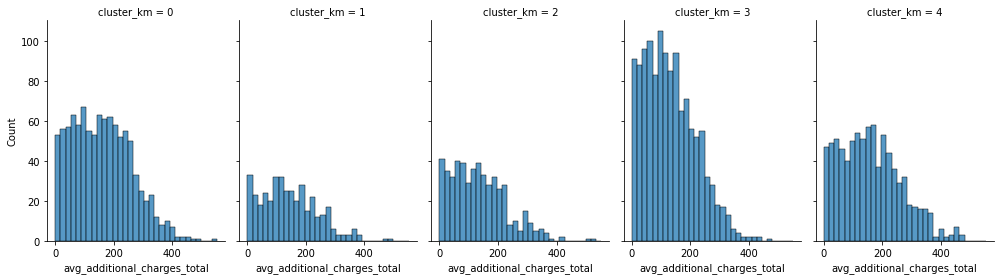

Распределение признака month_to_end_contract по кластерам


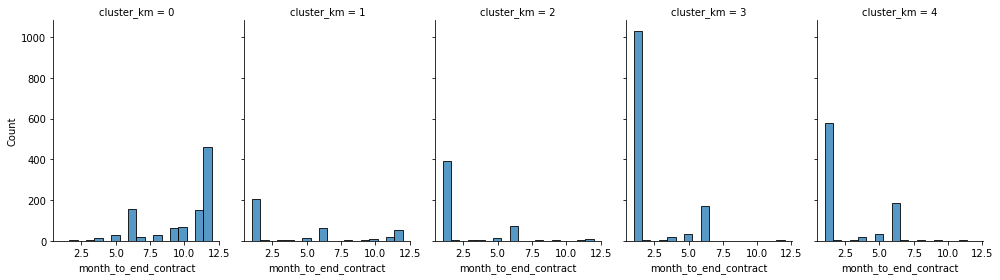

Распределение признака lifetime по кластерам


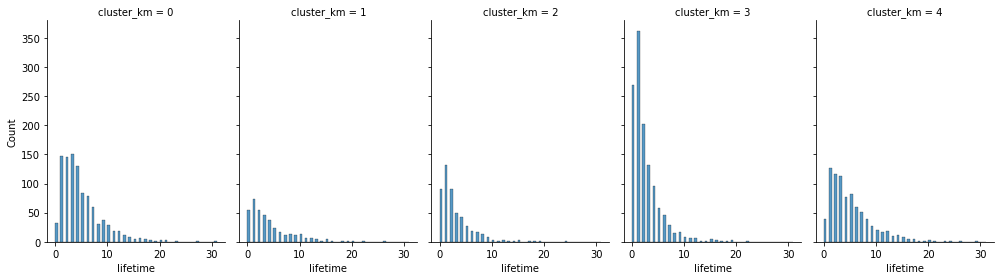

Распределение признака avg_class_frequency_total по кластерам


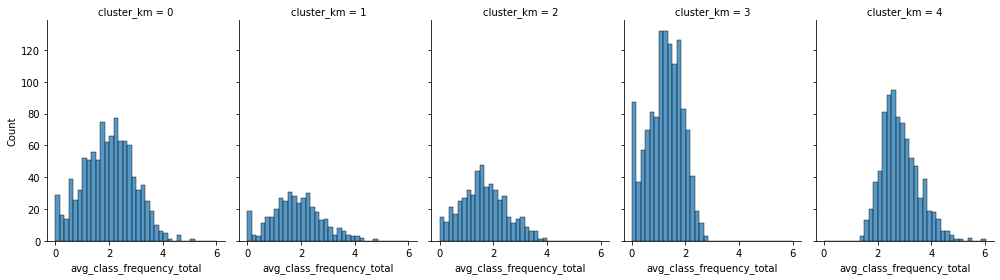

Распределение признака avg_class_frequency_current_month по кластерам


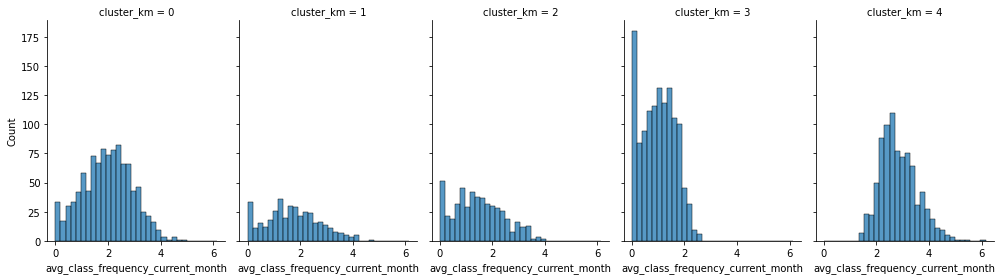

Распределение признака churn по кластерам


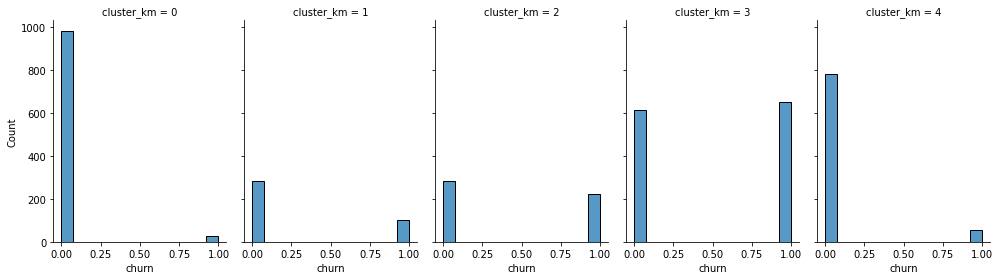

In [25]:
get_hist(df, df.columns)

**Что видим**

Получилось очень много гистограмм. 

1. С точки зрения распределения по признаку длительности текущего абонемента: распредления 2-го, 3-го, 4-го и 5-го кластеров смещены влево, при этом распределение данных первого кластера - вправо. 
2. По признаку `group_visits` данные 1-го, 2-го и 5-го кластеров приблизительно равномерно расположены относительно значений `0` и `1`. Распределение данных 3-го и 4-го кластеров смещены влево. 
3. Данные по возрасту почти во всех кластерах распределены нормально. Отличие лишь в общем кол-ве. 
4. Как заметили и раньше, с точки зрения среднего чека, который оставляют посетители фитнес-центров, также в либерах 5-й кластер и 1-й. 
5. Выводы по `avg_class_frequency_total` и `avg_class_frequency_current_month` на гистограммах подтверждают те, что были написаны ранее. 

Для каждого полученного кластера посчитаем долю оттока, чтобы понять, какой кластер более склонен к нему. 

In [26]:
df_churn = df.groupby('cluster_km')['churn'].agg(['count']).reset_index().sort_values('count', ascending=False)
df_churn['churn'] = df.query('churn == 1').groupby('cluster_km')['churn'].agg(['count'])
df_churn['ratio'] = df_churn['churn'] / df_churn['count']
df_churn.reset_index()

,index,cluster_km,count,churn,ratio
0,3,3,1262,649,0.514263
1,0,0,1010,28,0.027723
2,4,4,838,57,0.068019
3,2,2,505,224,0.443564
4,1,1,385,103,0.267532


Видим, что кластеры с точки зрения оттока очень сильно отличаются друг от друга. 
Очевидно, 3-й кластер наиболеее склонен к оттоку, так как доля оттока у него 51%. 
Наименее склонный к оттоку кластер 1-й. Всего 2,7%. 

## Выводы по проекту

Зависимости в данных, влияющие на отток клиентов, следующие: 
1. Очень сильная зависимость между показателями `month_to_end_contract` и `contract_period`.
2. Высокий уровень зависимости между признаками посещения фитнес-центров в целом и посещениями за предыдущий месяц. 
3. Относительно среднюю зависимость между признаками `promo_friends` и `partner`.
4. Относительно среднюю отрицательную зависимость между фактом оттока и временес с момента первого обращения в фитнес-центр. 
5. Достаточно низкую зависимость между остальными показателями, что говорит о том, что в дальнейшем при обучении нам не придется удалять много созависимых признаков. 

В рамках кластеризации клиентов мы получили 5 основных кластеров. В них: 
    1. Пользователи первого кластера чаще других пользуются промокодом от друзей. 
    2. 2-й кластер вообще не пользуется мобильной связью. Во всяком случае клиенты этого кластера не указали свой номер телефона. 
    3. Средний возвраст всех 5 кластеров приблизительно одинаковый. Разница совсем не существенная. 
    4. Клиенты, попавшие в 5-й кластер, больше других тратят денежные средства на дополнительные услуги в фитнес-центре. Чуть меньше затрат у пользователей 1-го кластера. 
    5. Самое большое время до окончания абонемента у клиентов, попавших в первый кластер. 
    6. Самое маленькое время до окончания абонемента у клиентов, попавших в 4-й кластер. 
    7. Чаще всего в среднем в фитнес-центры ходят клиенты 5-го кластера, как в целом за все время, так и за последний месяц. 
    8. Реже всех остальных в фитнес-центры ходят клиенты 4-го кластера одинаково за все периоды          наблюдений. 
    
В рамках разработки стратегии по взаимодействию с клиентами, в данному случае необходимо сконцентрироваться на наиболее уязвимом кластере клиентов - 3-м, поскольку он наименее надежный. 

Использовать можно следующие инструменты: 

    1. Скидочная программа лояльности. 
    2. Выстроенная коммуникация с клиентами (телефон, email, соц. сети, push-уведомления) 
    3. Активная работа с клиентами по реактивации и удержанию: программы посещения групповых занятий и т.д. 
    4. Разработать мини-стратегию на акции, стимулирующие покупку более длинных абонементов, поскольку клиенты с такими абонементами реже уходят. Таким образом, мы сможем снизить отток клиентов. 